# Projeto - Acidente de Trabalho

The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence ofan accident

In [1]:
!pip3 install bnlearn

In [2]:
!pip3 install category_encoders

In [3]:
# Importar bibliotecas
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pgmpy
import bnlearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, minmax_scale, RobustScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import category_encoders as ce 
from math import sqrt
import warnings
warnings.filterwarnings('ignore');
import plotly.express as px
import random

In [4]:
url = 'https://raw.githubusercontent.com/paulo-al-castro/datafiles/master/accident_data.csv'
db = pd.read_csv(url)

In [5]:
db.head()

Data   Countries     Local Industry Sector Accident Level  \
0  2016-01-01 00:00:00  Country_01  Local_01          Mining              I   
1  2016-01-02 00:00:00  Country_02  Local_02          Mining              I   
2  2016-01-06 00:00:00  Country_01  Local_03          Mining              I   
3  2016-01-08 00:00:00  Country_01  Local_04          Mining              I   
4  2016-01-10 00:00:00  Country_01  Local_04          Mining             IV   

  Potential Accident Level Genre  Employee ou Terceiro        Risco Critico  
0                       IV  Male           Third Party              Pressed  
1                       IV  Male              Employee  Pressurized Systems  
2                      III  Male  Third Party (Remote)         Manual Tools  
3                        I  Male           Third Party               Others  
4                       IV  Male           Third Party               Others

In [6]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Data                      439 non-null    object
 1   Countries                 439 non-null    object
 2   Local                     439 non-null    object
 3   Industry Sector           439 non-null    object
 4   Accident Level            439 non-null    object
 5   Potential Accident Level  439 non-null    object
 6   Genre                     439 non-null    object
 7   Employee ou Terceiro      439 non-null    object
 8   Risco Critico             439 non-null    object
dtypes: object(9)
memory usage: 31.0+ KB


In [7]:
# Verificar se existe alguma coluna sem valor atribuído
categorial = [var for var in db.columns]
db[categorial].isnull().sum()

Data                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Genre                       0
Employee ou Terceiro        0
Risco Critico               0
dtype: int64

### Columns description

**Data:** timestamp or time/date information

**Countries:** which country the accident occurred (anonymized)

**Local:** the city where the manufacturing plant is located (anonymized)

**Industry sector:** which sector the plant belongs to (Mining, metals,Others)

**Accident level:** from I to VI, it registers how severe was the accident (I means not severe ...VI most severe)

**Potential Accident Level:** Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)

**Genre:** ifthe person is male offemale

**Employee or Third Party:** if the injured person is an employee or a third party

**Critical Risk:** some description ofthe risk involved in the accident

**Verificar quantidade de itens diferentes em cada coluna**

In [8]:
db['Countries'].value_counts()

Country_01    263
Country_02    132
Country_03     44
Name: Countries, dtype: int64

In [9]:
db['Local'].value_counts()

Local_03    90
Local_05    59
Local_06    58
Local_01    57
Local_04    56
Local_10    44
Local_08    29
Local_02    24
Local_07    14
Local_12     4
Local_09     2
Local_11     2
Name: Local, dtype: int64

In [10]:
db['Industry Sector'].value_counts()

Mining    241
Metals    148
Others     50
Name: Industry Sector, dtype: int64

Percebe-se que poderemos ter problemas com a quantidade de 'Accident Level' (nível do acidente), pois os acidentes de maior nível são de menor quantidade.

In [11]:
db['Accident Level'].value_counts().sort_index()

I      328
II      40
III     31
IV      31
V        9
Name: Accident Level, dtype: int64

In [12]:
db['Potential Accident Level'].value_counts().sort_index()

I       49
II      95
III    106
IV     155
V       33
VI       1
Name: Potential Accident Level, dtype: int64

In [13]:
db['Genre'].value_counts()

Male      417
Female     22
Name: Genre, dtype: int64

In [14]:
db['Employee ou Terceiro'].value_counts()

Third Party             189
Employee                181
Third Party (Remote)     69
Name: Employee ou Terceiro, dtype: int64

In [15]:
print('Quantidade de itens diferentes em Risco Crítico: {}'.format(len(db['Risco Critico'].unique())))

db['Risco Critico'].value_counts()

Quantidade de itens diferentes em Risco Crítico: 34


Others                                       232
Pressed                                       24
Manual Tools                                  20
Chemical substances                           17
Venomous Animals                              16
Pressurized Systems / Chemical Substances     15
Cut                                           14
Projection                                    13
Bees                                          10
Fall                                           9
Vehicles and Mobile Equipment                  8
Fall prevention (same level)                   7
remains of choco                               7
Pressurized Systems                            7
Fall prevention                                6
Suspended Loads                                6
Blocking and isolation of energies             3
Power lock                                     3
Liquid Metal                                   3
Projection of fragments                        2
Machine Protection  

Possivelmente existem alguns Riscos Críticos que são identicos ou de certa forma parecidas. O ideal é juntar os riscos iguais com nomes diferentes. 
A coluna 'Risco Critico' possui dois itens, diferentes, de 'Not applicable', iremos colocá-los juntos.


In [16]:
db.loc[(db['Risco Critico'] == '\nNot applicable'), 'Risco Critico'] = 'Not applicable'
db.loc[(db['Risco Critico'] == 'Fall prevention (same level)') | (db['Risco Critico'] == 'Fall prevention'), 'Risco Critico'] = 'Fall'
db.loc[(db['Risco Critico'] == 'Projection of fragments') | (db['Risco Critico'] == 'Projection/Choco'), 'Risco Critico'] = 'Projection'
db.loc[(db['Risco Critico'] == 'Projection/Manual Tools'), 'Risco Critico'] = 'Manual Tools'
db.loc[(db['Risco Critico'] == 'Projection/Burning') , 'Risco Critico'] = 'Burn'
db.loc[(db['Risco Critico'] == 'Electrical Shock'), 'Risco Critico'] = 'Blocking and isolation of energies'
db.loc[(db['Risco Critico'] == 'Electrical installation'), 'Risco Critico'] = 'Power lock'
db.loc[(db['Risco Critico'] == 'Pressurized Systems') | (db['Risco Critico'] == 'Chemical substances'), 'Risco Critico'] = 'Pressurized Systems / Chemical Substances'

# Os novos valores atribuídos para o 'Risco Critico' ficaram assim:
print('Quantidade de itens diferentes em Risco Crítico: {}'.format(len(db['Risco Critico'].unique())))

db['Risco Critico'].value_counts()

Quantidade de itens diferentes em Risco Crítico: 23


Others                                       232
Pressurized Systems / Chemical Substances     39
Pressed                                       24
Fall                                          22
Manual Tools                                  21
Venomous Animals                              16
Projection                                    16
Cut                                           14
Bees                                          10
Vehicles and Mobile Equipment                  8
remains of choco                               7
Suspended Loads                                6
Blocking and isolation of energies             5
Power lock                                     4
Not applicable                                 3
Liquid Metal                                   3
Burn                                           2
Machine Protection                             2
Poll                                           1
Confined space                                 1
Plates              

**Tipos dos dados nas colunas**

In [17]:
db.dtypes

Data                        object
Countries                   object
Local                       object
Industry Sector             object
Accident Level              object
Potential Accident Level    object
Genre                       object
Employee ou Terceiro        object
Risco Critico               object
dtype: object

Vamos dividir a coluna 'Data' em quatro colunas de interesse: day (dia), month (mês), year (ano) e week_day (dia da semana).

In [18]:
db['Data'] = db['Data'].astype(str).str.split(' ', expand=True)[0]
db['Data'] = pd.to_datetime(db['Data'].astype(str), format='%Y-%m-%d').dt.date
db["Day"] = db['Data'].map(lambda x: x.day)
db["Month"] = db['Data'].map(lambda x: x.month)
db["Year"] = db['Data'].map(lambda x: x.year)
db['Week_day'] = db['Data'].map(lambda x: x.weekday())
db.drop(columns='Data', inplace=True)

In [19]:
# Reorganizar ordens das colunas
# Passar as colunas 'Day', 'Month', 'Year' e 'Week_day' para as primeiras posições do dataset e o 'Accident Level' para última coluna
cols = db.columns.to_list()
cols = [cols[-2]] + [cols[-3]] + [cols[-4]] + [cols[-1]] + cols[:3] + cols[4:8] + [cols[3]] 
db = db[cols]
db.head()


Year  Month  Day  Week_day   Countries     Local Industry Sector  \
0  2016      1    1         4  Country_01  Local_01          Mining   
1  2016      1    2         5  Country_02  Local_02          Mining   
2  2016      1    6         2  Country_01  Local_03          Mining   
3  2016      1    8         4  Country_01  Local_04          Mining   
4  2016      1   10         6  Country_01  Local_04          Mining   

  Potential Accident Level Genre  Employee ou Terceiro  \
0                       IV  Male           Third Party   
1                       IV  Male              Employee   
2                      III  Male  Third Party (Remote)   
3                        I  Male           Third Party   
4                       IV  Male           Third Party   

                               Risco Critico Accident Level  
0                                    Pressed              I  
1  Pressurized Systems / Chemical Substances              I  
2                               Manual Tools              I  
3                                     Others              I  
4                                     Others             IV

## Análise dos dados

In [20]:
def img_barplot(dataset, eixo_x, especie):
    '''Função para transformar os dados de interesse em gráfico de barras em modo stacked
    dataset -> banco de dados
    eixo_x -> coluna do dataset que ficará no eixo x do gráfico de barras
    especie -> coluna do dataset que divide o resultado em especies
    
    saída -> gráfico de barras mostrando a quantidade de acidentes pelo eixo_x dividido pela espécie
    '''
    eixo_y = 'Year'
    title = f'Gráfico de Quantidade de Acidentes em \'{eixo_x}\' dividido por \'{especie}\''
    dataset_dados = dataset.groupby(by=[eixo_x, especie])[eixo_y].count().reset_index()
    fig = px.bar(dataset_dados, x=eixo_x, y=eixo_y, color=especie, 
                 barmode = 'stack', title=title, labels={'Year':'Quantidade de Acidentes'})
    fig.show()

        Não existe a mesma variável 'Local' para 'Countries' diferentes. Logo a coluna 'Countries' poderá ser descartada:

In [21]:
x, species = 'Countries', 'Local'
img_barplot(db, x, species)

        Cada 'Local' tem somente um tipo de setor industrial ('Industry Sector'):

In [22]:
x, species = 'Local', 'Industry Sector'
img_barplot(db, x, species)

        Relação de setor industrial em cada país:

In [23]:
x, species = 'Countries', 'Industry Sector'
img_barplot(db, x, species)

In [24]:
x, species = 'Countries', 'Accident Level'
img_barplot(db, x, species)

        Quantidade de Nível de acidentes (Accident Level) por 'Industry Sector':

In [25]:
x, species = 'Industry Sector', 'Accident Level'
img_barplot(db, x, species)

        Quantidade de Nível de acidentes (Accident Level) por 'Risco Critico':     

In [26]:
x, species = 'Risco Critico', 'Accident Level'
img_barplot(db, x, species)

        Quantidade de Nível de acidentes (Accident Level) por 'Potential Accident Level':    
        Percebe-se que há uma relação de casualidade entre eles. O 'Potential Accident Level' não pode ser mais baixo que o 'Accident Level'.

In [27]:
x, species = 'Potential Accident Level', 'Accident Level'
img_barplot(db, x, species)

        Há uma relação no nível de acidente causados por 'Third Party':

In [28]:
x, species = 'Employee ou Terceiro', 'Accident Level'
img_barplot(db, x, species)

        Há uma relação entre país e tipo de empregado:

In [29]:
x, species = 'Countries', 'Employee ou Terceiro'
img_barplot(db, x, species)

        Há uma relação entre setor industrial e tipo de empregado:

In [30]:
x, species = 'Industry Sector', 'Employee ou Terceiro'
img_barplot(db, x, species)

In [31]:
x, species = 'Local', 'Accident Level'
img_barplot(db, x, species)

        Há uma relação entre local e tipo de empregado:

In [32]:
x, species = 'Local', 'Employee ou Terceiro'
img_barplot(db, x, species)

In [33]:
x, species = 'Accident Level', 'Genre'
img_barplot(db, x, species)

        Há relação entre gênero e países:

In [34]:
x, species = 'Countries', 'Genre'
img_barplot(db, x, species)

        Há relação entre local e gênero:

In [35]:
x, species = 'Local', 'Genre'
img_barplot(db, x, species)

        Existe uma relação de proporção entre gênero no setor da industria:
        Exemplo: Existem mais homens trabalhando em mining.

In [36]:
x, species = 'Industry Sector', 'Genre'
img_barplot(db, x, species)

        Há uma relação entre risco crítico e Potential Accident Level:

In [37]:
x, species = 'Risco Critico', 'Potential Accident Level'
img_barplot(db, x, species)

        Há relação entre país e risco crítico:

In [38]:
x, species = 'Risco Critico', 'Countries'
img_barplot(db, x, species)

In [39]:
x, species = 'Risco Critico', 'Genre'
img_barplot(db, x, species)

        Relação de acidente no dia da semana pelo setor industrial:

In [40]:
x, species = 'Week_day', 'Industry Sector'
img_barplot(db, x, species)

In [41]:
x, species = 'Week_day', 'Accident Level'
img_barplot(db, x, species)

        Quantidade de acidentes no dia da semana:

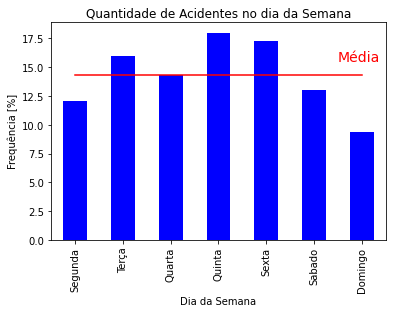

In [42]:

db_week = db['Week_day'].value_counts(normalize=True).sort_index()
db_week.index = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado', 'Domingo']

round(db_week*100, 2).plot.bar(color='Blue')
plt.plot([round((db_week*100).mean(), 2)]*7, 'red')
plt.text(5.5, 15.5, 'Média', color='red',fontsize=14)
plt.title('Quantidade de Acidentes no dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Frequência [%]')
plt.show()

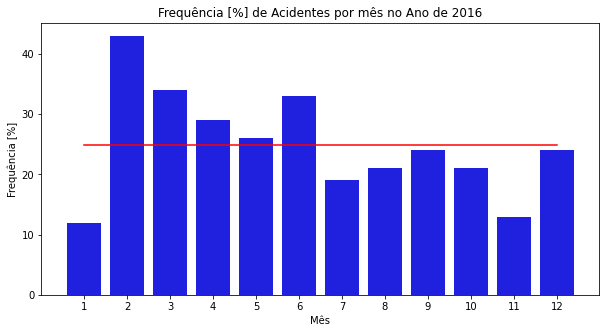

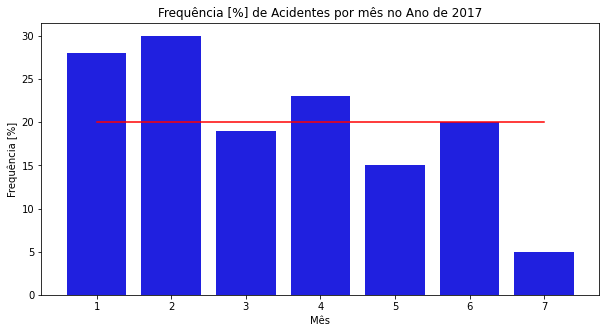

In [43]:
valor_2016 = db.loc[(db['Year'] == 2016), ['Month', 'Day']].groupby(by='Month').count().reset_index()
valor_2017 = db.loc[(db['Year'] == 2017), ['Month', 'Day']].groupby(by='Month').count().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Day', data=valor_2016, color='Blue')
plt.plot([valor_2016['Day'].mean()]*12, 'red')
plt.title('Frequência [%] de Acidentes por mês no Ano de 2016')
plt.xlabel('Mês')
plt.ylabel('Frequência [%]')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Day', data=valor_2017, color='Blue')
plt.plot([valor_2017['Day'].mean()]*7, 'red')
plt.title('Frequência [%] de Acidentes por mês no Ano de 2017')
plt.xlabel('Mês')
plt.ylabel('Frequência [%]')
plt.show()

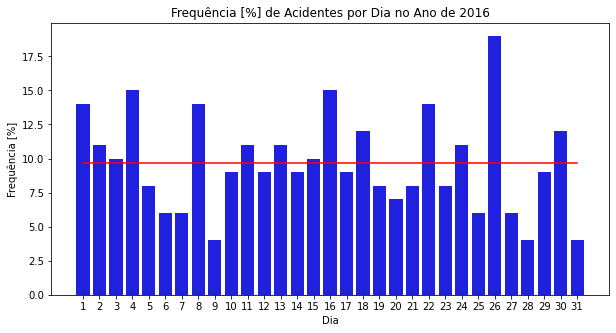

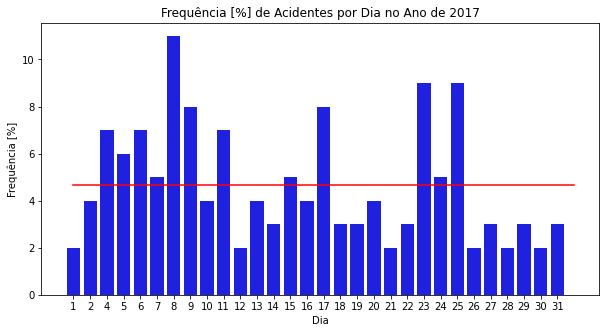

In [44]:
valor_2016 = db.loc[(db['Year'] == 2016), ['Month', 'Day']].groupby(by='Day').count().reset_index()
valor_2017 = db.loc[(db['Year'] == 2017), ['Month', 'Day']].groupby(by='Day').count().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Day', y='Month', data=valor_2016, color='Blue')
plt.plot([valor_2016['Month'].mean()]*31, 'red')
plt.title('Frequência [%] de Acidentes por Dia no Ano de 2016')
plt.xlabel('Dia')
plt.ylabel('Frequência [%]')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Day', y='Month', data=valor_2017, color='Blue')
plt.plot([valor_2017['Month'].mean()]*31, 'red')
plt.title('Frequência [%] de Acidentes por Dia no Ano de 2017')
plt.xlabel('Dia')
plt.ylabel('Frequência [%]')
plt.show()

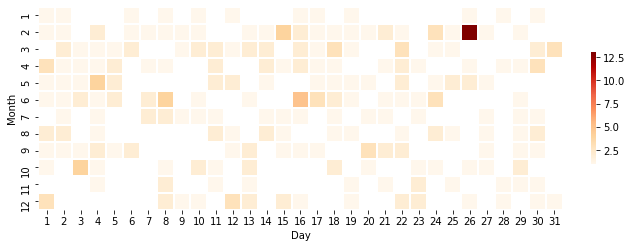

In [45]:
# db2 = db.loc[(db['Year'] == 2016), ['Month', 'Day']]
gp = pd.pivot_table(db.loc[(db['Year'] == 2016), ['Month', 'Day']], index='Month', columns='Day', aggfunc=len)

plt.figure(figsize=(10,10))
g = sns.heatmap(
    gp, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [46]:
# Converter os valores da colunas 'Potential Accident Level' e 'Accident Level' para decimal
def mudar_valor(database, coluna, buscar, saida):
    '''Função para mudar valor de determinada coluna no dataframe'''
    database.loc[database[coluna] == buscar, coluna] = saida
    return database

db = mudar_valor(db, coluna='Potential Accident Level', buscar='I', saida=1)
db = mudar_valor(db, coluna='Potential Accident Level', buscar='II', saida=2)
db = mudar_valor(db, coluna='Potential Accident Level', buscar='III', saida=3)
db = mudar_valor(db, coluna='Potential Accident Level', buscar='IV', saida=4)
db = mudar_valor(db, coluna='Potential Accident Level', buscar='V', saida=5)
db = mudar_valor(db, coluna='Potential Accident Level', buscar='VI', saida=6)
db = mudar_valor(db, coluna='Accident Level', buscar='I', saida=1)
db = mudar_valor(db, coluna='Accident Level', buscar='II', saida=2)
db = mudar_valor(db, coluna='Accident Level', buscar='III', saida=3)
db = mudar_valor(db, coluna='Accident Level', buscar='IV', saida=4)
db = mudar_valor(db, coluna='Accident Level', buscar='V', saida=5)

db.head()

Year  Month  Day  Week_day   Countries     Local Industry Sector  \
0  2016      1    1         4  Country_01  Local_01          Mining   
1  2016      1    2         5  Country_02  Local_02          Mining   
2  2016      1    6         2  Country_01  Local_03          Mining   
3  2016      1    8         4  Country_01  Local_04          Mining   
4  2016      1   10         6  Country_01  Local_04          Mining   

  Potential Accident Level Genre  Employee ou Terceiro  \
0                        4  Male           Third Party   
1                        4  Male              Employee   
2                        3  Male  Third Party (Remote)   
3                        1  Male           Third Party   
4                        4  Male           Third Party   

                               Risco Critico Accident Level  
0                                    Pressed              1  
1  Pressurized Systems / Chemical Substances              1  
2                               Manual Tools              1  
3                                     Others              1  
4                                     Others              4

**Ajuste de Labels**

É preciso rotular as colunas com formato strings para fazer uma análise de correlação.

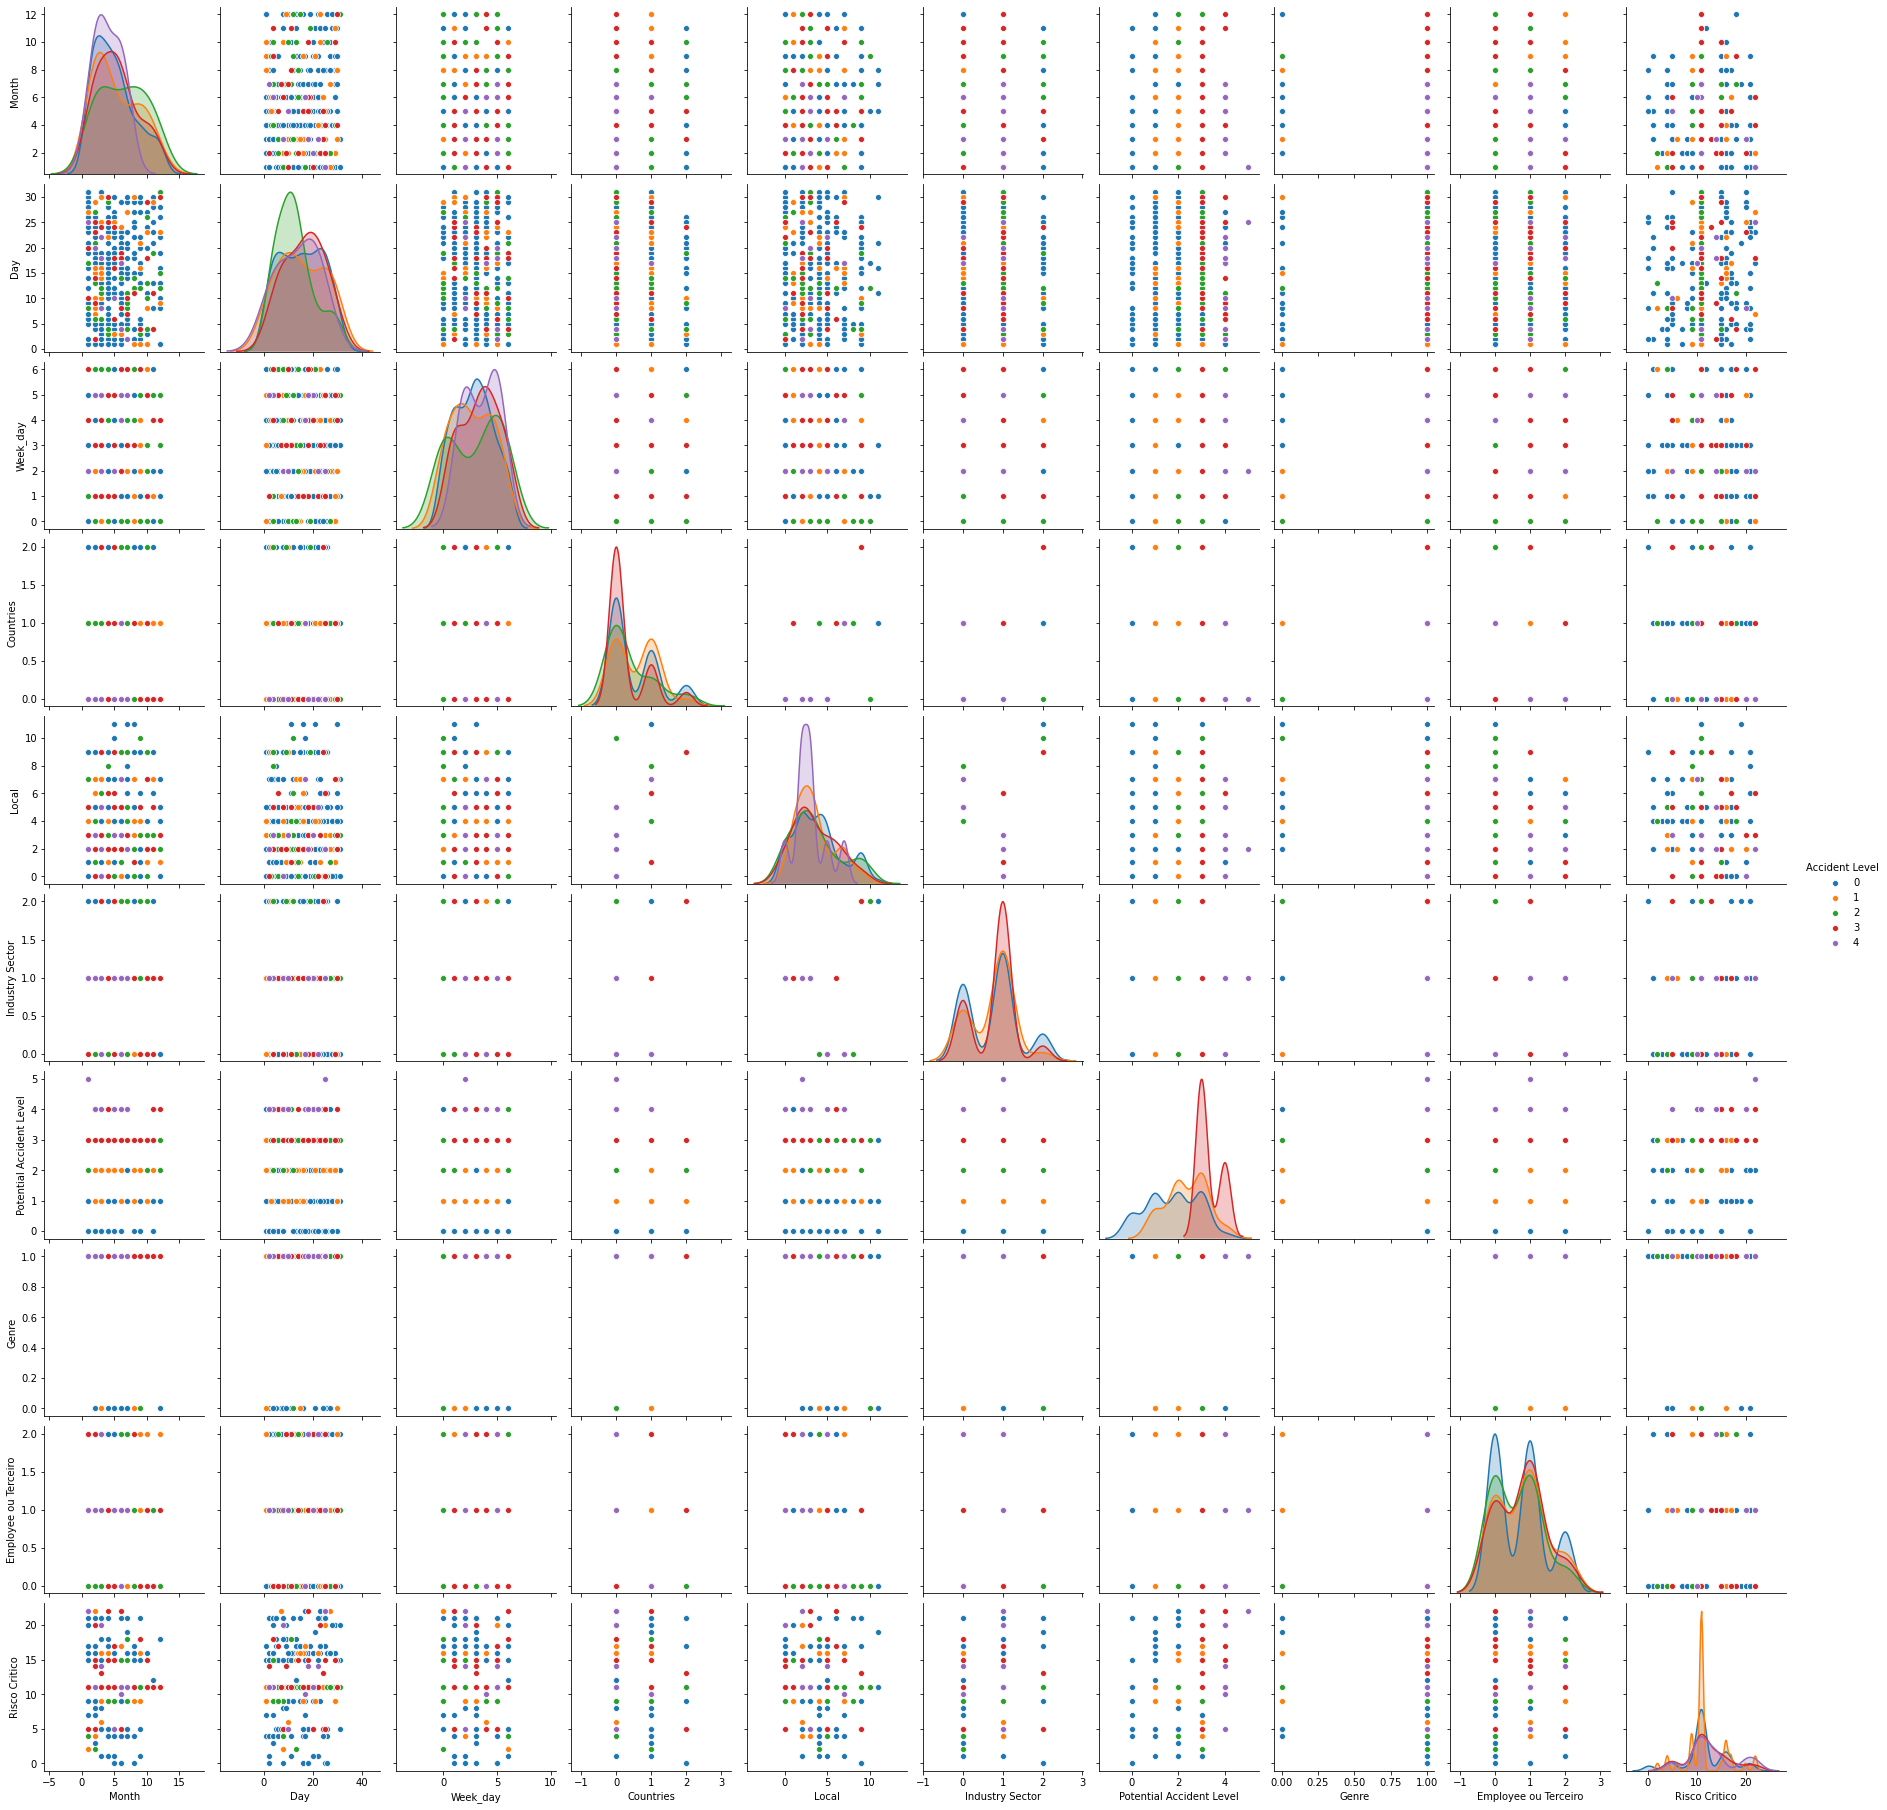

In [47]:
db1 = db.copy() # Cópia do dataset para rotular as categorias

# Função para transformar os rótulos de cada coluna para a função matrix plot
transform_dict = {col: LabelEncoder() for col in db1.iloc[:,4:]}
for col in db1.iloc[:,4:]:
    transform_dict[col].fit_transform(db1[col])

db1['Countries'] = transform_dict['Countries'].transform(db1['Countries'])
db1['Local'] = transform_dict['Local'].transform(db1['Local'])
db1['Industry Sector'] = transform_dict['Industry Sector'].transform(db1['Industry Sector'])
db1['Accident Level'] = transform_dict['Accident Level'].transform(db1['Accident Level'])
db1['Potential Accident Level'] = transform_dict['Potential Accident Level'].transform(db1['Potential Accident Level'])
db1['Genre'] = transform_dict['Genre'].transform(db1['Genre'])
db1['Employee ou Terceiro'] = transform_dict['Employee ou Terceiro'].transform(db1['Employee ou Terceiro'])
db1['Risco Critico'] = transform_dict['Risco Critico'].transform(db1['Risco Critico'])
db1['Year'] = db1['Year'].astype(int)
db1['Month'] = db1['Month'].astype(int)
db1['Day'] = db1['Day'].astype(int)
db1['Week_day'] = db1['Week_day'].astype(int)

# Plot Matrix
sns.pairplot(db1.iloc[:,1:], hue='Accident Level')

## Após a análise será descartado algumas colunas do dataset
        As colunas: 'Year', 'Month', 'Day' não são significativas para o processo

In [48]:
db.drop(columns=['Year', 'Month', 'Day'], inplace=True)
db.head()

Week_day   Countries     Local Industry Sector Potential Accident Level  \
0         4  Country_01  Local_01          Mining                        4   
1         5  Country_02  Local_02          Mining                        4   
2         2  Country_01  Local_03          Mining                        3   
3         4  Country_01  Local_04          Mining                        1   
4         6  Country_01  Local_04          Mining                        4   

  Genre  Employee ou Terceiro                              Risco Critico  \
0  Male           Third Party                                    Pressed   
1  Male              Employee  Pressurized Systems / Chemical Substances   
2  Male  Third Party (Remote)                               Manual Tools   
3  Male           Third Party                                     Others   
4  Male           Third Party                                     Others   

  Accident Level  
0              1  
1              1  
2              1  
3              1  
4              4

**Separar conjunto de treinamento e teste**

In [49]:
# Copiar dataset
db_modelo = db.copy()

prop = 0.2 # Valor utilizado para o conjunto de testes
randon_state = 20 # Valor aleatório para embaralhar as linhas do dataset

# Ajustar coluna 'Accident Level' e 'Potential Accident Level' para valores numericos
db_modelo['Accident Level'] = db_modelo['Accident Level'].astype(int)
db_modelo['Potential Accident Level'] = db_modelo['Potential Accident Level'].astype(int)
db_modelo['Week_day'] = db_modelo['Week_day'].astype(int)

# Função para transformar os rótulos de cada coluna
colunas_transformar = ['Countries', 'Local', 'Industry Sector', 'Genre', 'Employee ou Terceiro', 'Risco Critico']
transform_dict = {col: LabelEncoder() for col in db_modelo.loc[:,colunas_transformar]}
for col in db_modelo.loc[:,colunas_transformar]:
    transform_dict[col].fit_transform(db_modelo[col])
for coluna in colunas_transformar:
    db_modelo[coluna] = transform_dict[coluna].transform(db_modelo[coluna])

# Separar dados de entrada e rótulos (saída)
X = db_modelo.iloc[:,:-1]
y = db_modelo.iloc[:,-1]

# Separar dados de treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prop, random_state=randon_state)


## Classificador Naive Bayes

Utilizando a base de dados fornecida, criar um classificador baseado em Näive Bayes que classifique o nível do acidente dadas as demais informações. Discuta quais variáveis são mais ou menos relevantes para o processo de decisão.

In [50]:
# Função para apresentar os resultados:

def resultado_modelo(modelo, X_treino, X_teste, y_treino, y_teste, modelo_nome='Naive Bayes'):
    '''Está função cria os resultados de interesse apresentado pelo Naive Bayes'''

    print('Resultado do modelo utilizando validação cruzada com k-fold de 10')
    print()
    # Acurácia
    scores_acc = cross_val_score(modelo, X_treino, y_treino, cv = 10, scoring='accuracy')
    print('Cross-validation scores accurancy: {}'.format(scores_acc))
    print('Average cross-validation score accurancy: {}'.format(scores_acc.mean()))
    print()

    # Root Mean Square Error (RMSE)
    scores_rmse = cross_val_score(modelo, X_treino, y_treino, cv = 10, scoring='neg_root_mean_squared_error')*(-1)
    print('Cross-validation Root Mean Square Error (RMSE):{}'.format(scores_rmse))
    print('Average cross-validation Root Mean Square Error (RMSE): {}'.format(scores_rmse.mean()))
    print()

    # KAPPA (RMSE)
    scores_kappa = cross_val_score(modelo, X_treino, y_treino, cv = 10, scoring=make_scorer(cohen_kappa_score, greater_is_better=False))  
    print('Cross-validation kappa Score:{}'.format(scores_kappa))
    print('Average cross-validation kappa Score: {}'.format(scores_kappa.mean()))

    print()
    print('#'*100)
    print()

    print('Resultado do modelo no conjunto de treinamento e teste')
    print()
    # Acurácia treinamento e teste
    pred_treino = model.predict(X_treino)
    print('Test set Score: ', accuracy_score(y_teste, predicted))
    print('Training set score: ', accuracy_score(y_treino, pred_treino))
    # Estatística Kappa
    kappa = cohen_kappa_score(y_teste, predicted)
    print('Kappa Score do conjunto de teste: {}'.format(kappa))
    # RMSE
    rmse = mean_squared_error(y_teste, predicted)
    print('RMSE do conjunto de teste: {}'.format(rmse))
    print()
    # Relatorio de Classificação
    print('Relatório do conjunto de teste')
    print(classification_report(y_teste, predicted, target_names=['I', 'II', 'III', 'IV', 'V']))
    print()

    # Matriz de Confusão
    print('Matriz de Confusão do conjunto de teste')
    print()

    fig, ax = plt.subplots(dpi=100)
    disp = plot_confusion_matrix(modelo, X_teste, y_teste, cmap=plt.cm.Blues, 
                                 display_labels=['I', 'II', 'III', 'IV', 'V'], ax=ax) 
    plt.title('Matriz de Confusão do ' + str(modelo_nome))
    plt.xlabel("Valor Predito") 
    plt.ylabel("Valor Real") 
    plt.show() 

## Naive Bayes

In [51]:
#Create a MultinomialNB Classifier
model = MultinomialNB()

# # Train the model using the training sets
model.fit(X_train,y_train)

# #Predict Output
predicted= model.predict(X_test)

Resultado do modelo utilizando validação cruzada com k-fold de 10

Cross-validation scores accurancy: [0.75       0.77142857 0.77142857 0.74285714 0.74285714 0.74285714
 0.74285714 0.74285714 0.74285714 0.74285714]
Average cross-validation score accurancy: 0.7492857142857143

Cross-validation Root Mean Square Error (RMSE):[1.22474487 1.13389342 1.13389342 1.18321596 1.18321596 1.05559733
 1.09544512 1.05559733 1.24211801 1.24211801]
Average cross-validation Root Mean Square Error (RMSE): 1.1549839402976598

Cross-validation kappa Score:[-0.         -0.         -0.         -0.         -0.         -0.06804734
 -0.         -0.         -0.         -0.        ]
Average cross-validation kappa Score: -0.006804733727810641

####################################################################################################

Resultado do modelo no conjunto de treinamento e teste

Test set Score:  0.7386363636363636
Training set score:  0.7492877492877493
Kappa Score do conjunto de teste: 0.0
RM

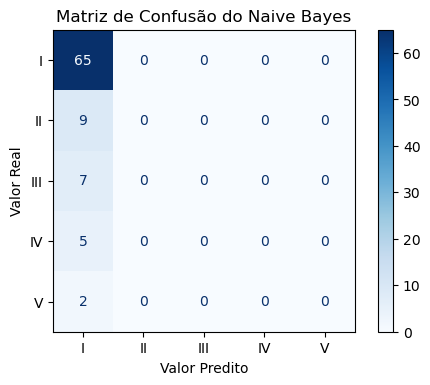

In [52]:
resultado_modelo(model, X_train, X_test, y_train, y_test)

**Análise dos parâmetros mais importantes do Naive Bayes**

In [53]:
pd.DataFrame(model.coef_, columns=X_train.columns.values.tolist(), index=model.classes_)

Week_day  Countries     Local  Industry Sector  Potential Accident Level  \
1 -2.142283  -3.817159 -1.820161        -3.458328                 -2.164083   
2 -2.330200  -3.875100 -2.052569        -3.556646                 -1.929190   
3 -2.089663  -4.182898 -1.998096        -3.202069                 -1.826246   
4 -2.038791  -4.470209 -2.072314        -3.458608                 -1.831152   
5 -2.045208  -4.610158 -2.084429        -3.511545                 -1.692387   

      Genre  Employee ou Terceiro  Risco Critico  
1 -3.238204             -3.488943      -0.728736  
2 -3.280393             -3.351852      -0.678981  
3 -3.202069             -3.607534      -0.785411  
4 -3.253814             -3.553918      -0.747532  
5 -3.223863             -3.106080      -0.825968

In [54]:
pd.DataFrame(model.feature_count_, columns=X_train.columns.values.tolist(), index=model.classes_)

Week_day  Countries   Local  Industry Sector  Potential Accident Level  \
1     741.0      138.0  1023.0            198.0                     725.0   
2      74.0       15.0    98.0             21.0                     111.0   
3      72.0        8.0    79.0             23.0                      94.0   
4      90.0        7.0    87.0             21.0                     111.0   
5      25.0        1.0    24.0              5.0                      36.0   

   Genre  Employee ou Terceiro  Risco Critico  
1  247.0                 192.0         3049.0  
2   28.0                  26.0          390.0  
3   23.0                  15.0          268.0  
4   26.0                  19.0          330.0  
5    7.0                   8.0           87.0

In [55]:
pd.DataFrame(np.e**model.feature_log_prob_*100, columns=X_train.columns.values.tolist(), index=model.classes_)

Week_day  Countries      Local  Industry Sector  Potential Accident Level  \
1  11.738649   2.199019  16.199968         3.148236                 11.485524   
2   9.727626   2.075227  12.840467         2.853437                 14.526589   
3  12.372881   1.525424  13.559322         4.067797                 16.101695   
4  13.018598   1.144492  12.589413         3.147353                 16.022890   
5  12.935323   0.995025  12.437811         2.985075                 18.407960   

      Genre  Employee ou Terceiro  Risco Critico  
1  3.923430              3.053314      48.251859  
2  3.761349              3.501946      50.713359  
3  4.067797              2.711864      45.593220  
4  3.862661              2.861230      47.353362  
5  3.980100              4.477612      43.781095

In [56]:
 np.e**(model.class_log_prior_)

array([0.74928775, 0.08831909, 0.06837607, 0.07407407, 0.01994302])

In [57]:
prob = np.e**(model.feature_log_prob_[4, :])
pd.DataFrame(np.round(prob*100, 2), 
             index=X_train.columns.values.tolist()).sort_values(by=0, ascending=False).rename(columns={0:'Importância'})

Importância
Risco Critico                   43.78
Potential Accident Level        18.41
Week_day                        12.94
Local                           12.44
Employee ou Terceiro             4.48
Genre                            3.98
Industry Sector                  2.99
Countries                        1.00

## Classificador Bayesiano com estrutura determinada a partir dos dados

Utilizando a base de dados fornecida, criar um classificador bayesiano com estrutura determinada a partir dos dados, teste diferentes parâmetros de treinamento de modo a tentar encontrar um modelo que supere o modelo Näive Bayes. Discuta quais variáveis são mais ou menos relevantes para o processo de decisão

In [58]:
def pred_bayes(data, modelo_treinado):
    '''Função para predição dos valores em um modelo Bayesiano
    
    data -> dataset em formato pandas (valor de saida ou rótulo terá que estar na última coluna do dataset)
    modelo -> modelo da rede Bayesiana treinada pelo bnlearn.parameter_learning.fit
    
    saída -> pandas series com os valores da predição da rede bayesiana
    '''
    
    pred_list = []
    saida = data.columns.values[-1]
    
    for row in range(len(data)):
        evidencia = {}
        for column in data.columns.values[:-1]:
            valor = data.iloc[row].loc[column]
            evidencia[column] = valor
        
        # Realizar inferência no modelo treinado
        prob_row = bnlearn.inference.fit(modelo_treinado, variables=[saida], evidence=evidencia, verbose=0)
        
        prob_to_list = prob_row.values.tolist() # transformar saída da inferência em lista
        max_value = max(prob_to_list) # Pegar valor máximo da lista
        pred = int(prob_to_list.index(max_value)) + 1 # Valor de saída (index + 1)

        pred_list.append(pred)
        
    return pd.Series(np.array(pred_list))

def kfoldcv(indices, k = 10, seed = randon_state):
    '''Função kfold'''
    
    size = len(indices)
    subset_size = round(size / k)
    random.Random(seed).shuffle(indices)    
    
    subsets = [indices[x:x+subset_size] for x in range(0, len(indices), subset_size)]    
    
    kfolds = []
    for i in range(k):
        test = subsets[i]
        train = []
        for subset in subsets:
            if subset != test:
                train.append(subset)
        kfolds.append((train,test))
        
    return kfolds

def dictSplitTrainTest(dataset_treino, k=10, seed=20):
    '''Retorna um dicionário contendo os indíces de treinamento e teste em kfolds'''
    db_treino = dataset_treino.reset_index(drop=True)
    indice = [x for x in range(len(db_treino))]
    divisao = kfoldcv(indice, k=k, seed=seed)

    cv = {}
    for j in range(len(divisao)):
        treino = 'treino' + str(j)
        teste = 'teste' + str(j)
        cv[treino] = []
        cv[teste] = []
        cv[teste] += divisao[j][1]

        for lista in divisao[j][0]:
            cv[treino] += lista
    
    return cv

def cvBayes(data_treino, modelo_bayes, k=10, seed=20):
    '''Realizar validação cruzada kfold
    
    Retorna 3 listas com k resultados, sendo:
        primeira lista de acuracidade;
        segunda lista o de kappa score;
        terceira lista o de rmse;
    '''

    lista_cv_acc = []
    lista_cv_kappa = []
    lista_cv_rmse = []
    
    dicSplit = dictSplitTrainTest(data_treino, k=k, seed=seed) #Chamar função para dividir kfold treino/teste
    
    for i in range(int(len(dicSplit)/2)):
        
        # Separar indices do conjunto de treinamento
        nome_treino = 'treino' + str(i)
        nome_teste = 'teste' + str(i)
        df_treino = data_treino.iloc[dicSplit[nome_treino]]
        df_teste = data_treino.iloc[dicSplit[nome_teste]]
        df_inteiro = data_treino.iloc[dicSplit[nome_treino]+dicSplit[nome_teste]]
        
        # Treinar o modelo bayesiano
        modelo_treinado = bnlearn.parameter_learning.fit(modelo_bayes, df_inteiro, verbose=0)
        
        # Predição no conjunto de teste
        predicao = pred_bayes(data=df_teste, modelo_treinado=modelo_treinado)
        
        y_teste = df_teste.iloc[:,-1].astype(int)
        acc = accuracy_score(y_teste, predicao)
        kappa = cohen_kappa_score(y_teste, predicao)
        rmse = mean_squared_error(y_teste, predicao)
        
        lista_cv_acc.append(acc)
        lista_cv_kappa.append(kappa)
        lista_cv_rmse.append(rmse)
        
    return lista_cv_acc, lista_cv_kappa, lista_cv_rmse

**Achar modelo ótimo da rede Bayesiana Estruturada para o conjunto do dataset**

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
[bnlearn] >Plot based on BayesianModel


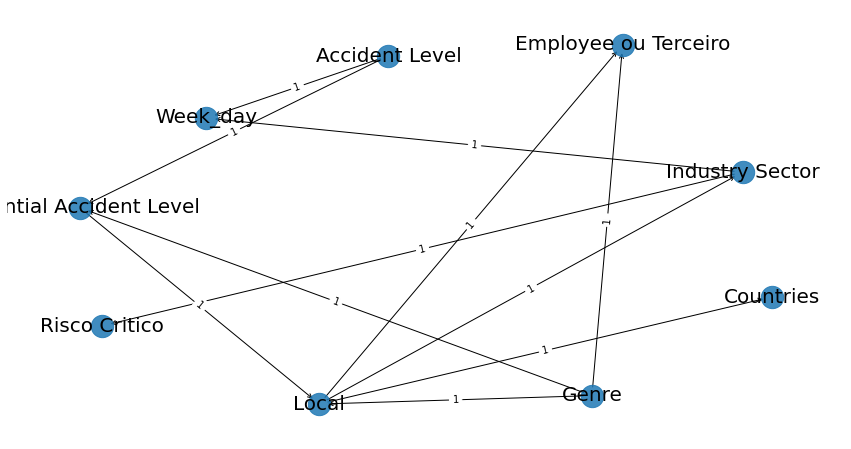

In [59]:
#Buscar modelo otimo hill climbing search and metric function 'K2'
modelo_bayes_otimo = bnlearn.structure_learning.fit(db_modelo, methodtype='hc', scoretype='k2')

# Gráfico do modelo
G = bnlearn.plot(modelo_bayes_otimo)

In [60]:
edges = [('Local', 'Industry Sector'), ('Local', 'Countries'), ('Local', 'Employee ou Terceiro'), 
         ('Industry Sector', 'Risco Critico'), ('Industry Sector', 'Week_day'), 
         ('Potential Accident Level', 'Local'), ('Genre', 'Local'), ('Genre', 'Employee ou Terceiro'), 
         ('Genre', 'Potential Accident Level'), ('Accident Level', 'Potential Accident Level'), 
         ('Accident Level', 'Week_day')]

**Treinar e testar o modelo Bayesiano**

In [61]:
# Juntar data de treinamento X com y (entrada e saída)
db_b_treino = X_train.copy() # Será utilizado na validação cruzada kfold
db_b_treino['Accident Level'] = y_train

# Juntar data de teste X com y (entrada e saída)
db_b_teste = X_test.copy()
db_b_teste['Accident Level'] = y_test

# Treinar o modelo bayesiano
modelo_treinado = bnlearn.parameter_learning.fit(modelo_bayes_otimo, db_modelo, verbose=0)

#Create a Bayes Classifier no conjunto de teste
pred_test = pred_bayes(data=db_b_teste, modelo_treinado=modelo_treinado)

#Create a Bayes Classifier no conjunto de treinamento
pred_train = pred_bayes(data=db_b_treino, modelo_treinado=modelo_treinado)

Resultado do modelo utilizando validação cruzada com k-fold de 10

Cross-validation scores accurancy:[0.8571428571428571, 0.7142857142857143, 0.8, 0.7428571428571429, 0.7714285714285715, 0.8, 0.7142857142857143, 0.6, 0.7714285714285715, 0.8571428571428571]
Average cross-validation score accurancy: 0.7628571428571428

Cross-validation kappa Score:[0.5084269662921348, 0.18414918414918413, -0.042553191489361764, 0.1964285714285714, 0.0572390572390572, 0.2620481927710844, 0.10025706940874035, 0.0, 0.23287671232876717, 0.5635910224438903]
Average cross-validation kappa Score: 0.20624635845720682

Cross-validation RMSE:[0.22857142857142856, 0.8571428571428571, 1.6, 1.2857142857142858, 1.7428571428571429, 0.2857142857142857, 1.6571428571428573, 2.1142857142857143, 0.8571428571428571, 0.9714285714285714]
Average cross-validation RMSE: 1.1600000000000001

####################################################################################################

Resultado do modelo no conjunto de trei

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'I'),
  Text(0, 1.5, 'II'),
  Text(0, 2.5, 'III'),
  Text(0, 3.5, 'IV'),
  Text(0, 4.5, 'V')])

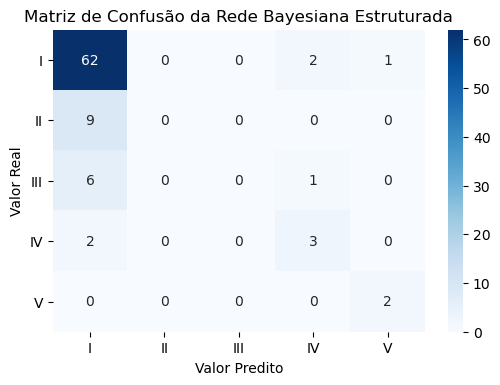

In [62]:
print('Resultado do modelo utilizando validação cruzada com k-fold de 10')
print()

lista_cv_acc, lista_cv_kappa, lista_cv_rmse = cvBayes(data_treino=db_b_treino, 
                                                      modelo_bayes=modelo_bayes_otimo, k=10, seed=20)

# Acurácia
print('Cross-validation scores accurancy:{}'.format(lista_cv_acc))
print('Average cross-validation score accurancy: {}'.format(np.mean(lista_cv_acc)))
print()

# KAPPA (RMSE)
print('Cross-validation kappa Score:{}'.format(lista_cv_kappa))
print('Average cross-validation kappa Score: {}'.format(np.mean(lista_cv_kappa)))
print()

# RMSE
print('Cross-validation RMSE:{}'.format(lista_cv_rmse))
print('Average cross-validation RMSE: {}'.format(np.mean(lista_cv_rmse)))

print()
print('#'*100)
print()

print('Resultado do modelo no conjunto de treinamento e teste')
print()
y_teste = db_b_teste.iloc[:,-1].astype(int)
y_treino = db_b_treino.iloc[:,-1].astype(int)

# Acurácia treinamento e teste
print('Test set Score: ', accuracy_score(y_teste, pred_test))
print('Training set score: ', accuracy_score(y_treino,pred_train))
print()

# Estatística Kappa
kappa = cohen_kappa_score(y_teste, pred_test)
print('Kappa Score do conjunto de teste:{}'.format(kappa))
print()

# Estatística RMSE
rmse = mean_squared_error(y_teste, pred_test)
print('RMSE conjunto de teste:{}'.format(rmse))
print()

# Relatorio de Classificação
print('Relatório do conjunto de teste')
print(classification_report(y_teste, pred_test, target_names=['I', 'II', 'III', 'IV', 'V']))
print()

#Get the confusion matrix
cf_matrix = confusion_matrix(y_teste, pred_test)
fig, ax = plt.subplots(dpi=100)
sns.heatmap(cf_matrix, xticklabels=['I', 'II', 'III', 'IV', 'V'], 
            yticklabels=['I', 'II', 'III', 'IV', 'V'], annot=True, cmap='Blues' , ax=ax)
plt.title('Matriz de Confusão da Rede Bayesiana Estruturada')
plt.xlabel("Valor Predito") 
plt.ylabel("Valor Real") 
plt.yticks(rotation=0) 

## Decision Tree

        Teste com o método de Árvore de Decisão

In [63]:
#Create a MultinomialNB Classifier
model = DecisionTreeClassifier()

# # Train the model using the training sets
model.fit(X_train,y_train)

# #Predict Output
predicted= model.predict(X_test)

In [66]:
import graphviz 
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=X_train.columns.values.tolist(),  
                                class_names='Accidente Level',  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  

Resultado do modelo utilizando validação cruzada com k-fold de 10

Cross-validation scores accurancy: [0.77777778 0.71428571 0.74285714 0.6        0.62857143 0.68571429
 0.62857143 0.77142857 0.71428571 0.68571429]
Average cross-validation score accurancy: 0.6949206349206349

Cross-validation Root Mean Square Error (RMSE):[0.94280904 0.77459667 1.18321596 1.15881713 1.30930734 1.12122382
 1.01418511 1.01418511 1.10840941 1.10840941]
Average cross-validation Root Mean Square Error (RMSE): 1.0735158999840064

Cross-validation kappa Score:[-0.44401544 -0.39130435 -0.44664032 -0.14930556 -0.09181637 -0.11764706
 -0.07284768 -0.3        -0.03314917 -0.26931106]
Average cross-validation kappa Score: -0.2316037007799705

####################################################################################################

Resultado do modelo no conjunto de treinamento e teste

Test set Score:  0.7272727272727273
Training set score:  0.9401709401709402
Kappa Score do conjunto de teste: 0.297171

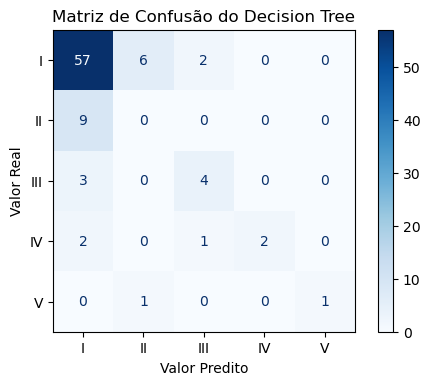

In [65]:
resultado_modelo(model, X_train, X_test, y_train, y_test, modelo_nome='Decision Tree')